### Water Quality Prediction - Principle of Component Analyisis.

In this notebook we are going to continue from the previous notebook, we are going to build models that will classify water potability given certain features.


> The rest of the notebook will remain the same like the previous notebook, however we are going to use different dataset.

https://www.kaggle.com/datasets/vanthanadevi08/water-quality-prediction/data

### Importing Packages

In teh next code cell we are going to import all the packages that we are going to use in this notebook.

In [169]:
!pip install -q helperfns kaggle

In [170]:
import numpy as np
import pandas as pd
from torch import nn
import torch
import torch.nn.functional as F


import os
import time
import random
import warnings

from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix
from sklearn.utils import resample
from matplotlib.colors import ListedColormap
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score, confusion_matrix
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import preprocessing
from helperfns.utils import hms_string

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb

warnings.filterwarnings("ignore")

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("xgb:", xgb.__version__)
print("torch: ", torch.__version__)


pandas: 2.2.2
numpy: 1.26.4
xgb: 2.1.2
torch:  2.5.1+cu121


### Seeding

Next we are going to set the `seed` to all the random operations that we are going to have in this notebook for reproducivity.

In [171]:
SEED = 7

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True


### Device
In the following code cell we are going to get `gpu` device if possible

In [172]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataset.

The dataset that we will be using in this notebook was downloaded from the following url:

https://www.kaggle.com/datasets/vanthanadevi08/water-quality-prediction

We are going to load the dataset from the file that we saved from the previous notebook.

In [173]:
# with open('kaggle.json', 'r') as reader:
#   keys = json.loads(reader.read())
#   os.environ['KAGGLE_USERNAME'] = keys['username']
#   os.environ['KAGGLE_KEY'] = keys['key']

In [174]:
!kaggle datasets download vanthanadevi08/water-quality-prediction --unzip

Dataset URL: https://www.kaggle.com/datasets/vanthanadevi08/water-quality-prediction
License(s): unknown
 96% 101M/105M [00:00<00:00, 227MB/s] 
100% 105M/105M [00:00<00:00, 217MB/s]


In [175]:
data_path = 'Water Quality Prediction.csv'
dataframe = pd.read_csv(data_path)
dataframe.head()

,Index,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,...,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Month,Day,Time of Day,Target
0,0,8.332988,0.000083,8.605777,122.799772,3.710000e-52,3.434827,Colorless,0.022683,0.607283,...,3.708178,2.270000e-15,332.118789,NaN,NaN,43.493324,January,29.0,4.0,0
1,1,6.917863,0.000081,3.734167,227.029851,7.850000e-94,1.245317,Faint Yellow,0.019007,0.622874,...,3.292038,8.020000e-07,284.641984,Lake,15.348981,71.220586,November,26.0,16.0,0
2,2,5.443762,0.020106,3.816994,230.995630,5.290000e-76,0.528280,Light Yellow,0.319956,0.423423,...,3.560224,7.007989e-02,570.054094,River,11.643467,44.891330,January,31.0,8.0,0
3,3,7.955339,0.143988,8.224944,178.129940,4.000000e-176,4.027879,Near Colorless,0.166319,0.208454,...,3.516907,2.468295e-02,100.043838,Ground,10.092392,60.843233,April,1.0,21.0,0
4,4,8.091909,0.002167,9.925788,186.540872,4.170000e-132,3.807511,Light Yellow,0.004867,0.222912,...,3.177849,3.296139e-03,168.075545,Spring,15.249416,69.336671,June,29.0,7.0,0


Let's remove some columns that does not have anything to do with water quality for example columns like:


1. Month
2. Day
3. Time of the Day

In [176]:
dataframe = dataframe[['pH', 'Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc', 'Color',
       'Turbidity', 'Fluoride', 'Copper', 'Odor', 'Sulfate', 'Conductivity',
       'Chlorine', 'Manganese', 'Total Dissolved Solids', 'Source',
       'Water Temperature', 'Air Temperature', 'Target']]
dataframe.rename(columns = {i: i.lower() for i in dataframe.columns}, inplace=True)
dataframe.head(2)

,ph,iron,nitrate,chloride,lead,zinc,color,turbidity,fluoride,copper,odor,sulfate,conductivity,chlorine,manganese,total dissolved solids,source,water temperature,air temperature,target
0,8.332988,0.000083,8.605777,122.799772,3.710000e-52,3.434827,Colorless,0.022683,0.607283,0.144599,1.626212,87.266538,471.683357,3.708178,2.270000e-15,332.118789,NaN,NaN,43.493324,0
1,6.917863,0.000081,3.734167,227.029851,7.850000e-94,1.245317,Faint Yellow,0.019007,0.622874,0.437835,1.686049,144.010981,432.844908,3.292038,8.020000e-07,284.641984,Lake,15.348981,71.220586,0


We are going to change the column value of our dataframe to be categorical. We want to be either `bad` or `good` based on the label that we have, We are going to say the target `0` will represent bad quality and `1` will represent good quality.

In [177]:
dataframe.target = dataframe.target.apply(lambda x: "bad" if x == 0 else 'good')
dataframe.head(3)

,ph,iron,nitrate,chloride,lead,zinc,color,turbidity,fluoride,copper,odor,sulfate,conductivity,chlorine,manganese,total dissolved solids,source,water temperature,air temperature,target
0,8.332988,0.000083,8.605777,122.799772,3.710000e-52,3.434827,Colorless,0.022683,0.607283,0.144599,1.626212,87.266538,471.683357,3.708178,2.270000e-15,332.118789,NaN,NaN,43.493324,bad
1,6.917863,0.000081,3.734167,227.029851,7.850000e-94,1.245317,Faint Yellow,0.019007,0.622874,0.437835,1.686049,144.010981,432.844908,3.292038,8.020000e-07,284.641984,Lake,15.348981,71.220586,bad
2,5.443762,0.020106,3.816994,230.995630,5.290000e-76,0.528280,Light Yellow,0.319956,0.423423,0.431588,3.414619,275.702107,990.201209,3.560224,7.007989e-02,570.054094,River,11.643467,44.891330,bad


Next we are going to check if there are `NA` and `null` values in our dataframe.

In [178]:
dataframe.isna().any()

,0
ph,True
iron,True
nitrate,True
chloride,True
lead,True
zinc,True
color,True
turbidity,True
fluoride,True
copper,True


We are going to drop `na` values from our dataframe and check if there will be still `na` values.

In [179]:
dataframe.dropna(inplace=True)

In [180]:
dataframe.isna().any()

,0
ph,False
iron,False
nitrate,False
chloride,False
lead,False
zinc,False
color,False
turbidity,False
fluoride,False
copper,False


Now that we don't have null and `na` values we want to check the value counts for our target label.

In [181]:
dataframe.target.value_counts()

,count
target,
bad,569004
good,170144


We can see that we have misbalance of labels, so we want to balance these labels just like what we did in the first notebook.

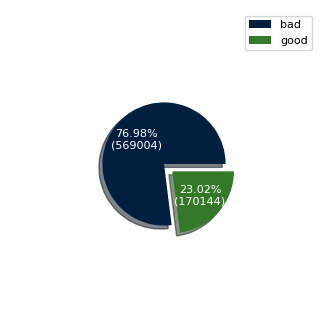

In [182]:
dist_label = {i:0 for i in dataframe.target.unique()}
for val in dataframe.target:
  dist_label[val] += 1

def fmt(x, total):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)

colors = ['#001F3F', '#347928']

plt.figure(figsize=(4, 4))
plt.pie(
    dist_label.values(), labels=dist_label.keys(), autopct=lambda x: fmt(x, len(dataframe)),
    textprops={'color': 'white', 'fontsize':8}, radius=.5, explode=[.0, .09],
    colors=colors, shadow=True,
)
plt.legend(fontsize=8)
plt.show()

In the following code cell we are going to balance the dataset based on the `target` column value. Our dataset is quite large, we want to take only `170_000` examples for each class label.

In [183]:
MAX_EXAMPLES = 170_000

# Separate the majority and minority classes
majority_class = dataframe[dataframe['target'] == dataframe['target'].value_counts().idxmax()].iloc[:MAX_EXAMPLES]
minority_class = dataframe[dataframe['target'] == dataframe['target'].value_counts().idxmin()].iloc[:MAX_EXAMPLES]

# Downsample majority class to the size of the minority class
majority_downsampled = resample(
    majority_class,
    replace=False,  # without replacement
    n_samples = MAX_EXAMPLES,  # match minority class size
    random_state=SEED  # for reproducibility
)


# Combine downsampled majority and original minority
balanced_df = pd.concat([majority_downsampled, minority_class]).reset_index(drop=True)

balanced_df.head(3)

,ph,iron,nitrate,chloride,lead,zinc,color,turbidity,fluoride,copper,odor,sulfate,conductivity,chlorine,manganese,total dissolved solids,source,water temperature,air temperature,target
0,7.083407,3.470000e-06,8.133180,153.619755,9.920000e-214,0.518170,Near Colorless,0.006009,0.164438,0.401747,2.143813,194.345827,627.195349,3.355364,2.420000e-05,21.373051,Ground,18.082142,48.727026,bad
1,7.315485,1.030000e-12,5.039845,198.074111,6.020000e-128,0.513111,Near Colorless,0.002104,1.551615,0.460328,1.633278,104.128486,392.977599,2.798649,9.302260e-03,300.182460,Ground,21.599274,60.865268,bad
2,7.692549,6.638021e-03,5.779490,86.862084,9.130000e-40,0.317524,Colorless,0.113082,0.597914,0.443267,2.593632,229.717689,705.337097,3.459457,8.350000e-12,284.713504,Stream,33.150013,67.537900,bad


We can check again if the labels are now balanced using a `pie` chat.

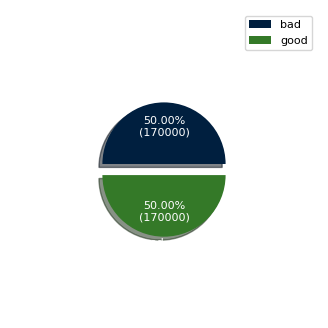

In [184]:
dist_label = {i:0 for i in balanced_df.target.unique()}
for val in balanced_df.target:
  dist_label[val] += 1

def fmt(x, total):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)

colors = ['#001F3F', '#347928']

plt.figure(figsize=(4, 4))
plt.pie(
    dist_label.values(), labels=dist_label.keys(), autopct=lambda x: fmt(x, len(balanced_df)),
    textprops={'color': 'white', 'fontsize':8}, radius=.5, explode=[.0, .09],
    colors=colors, shadow=True,
)
plt.legend(fontsize=8)
plt.show()

### Datset Splitting

The next thing that we are going to do is to create 2 subset from our dataframe which are:

1. ``train``
2. ``test``

> The train dataset is going to be used to ``train`` our algorithm and the ``test`` dataset will be used to evaluate the trained model.

For dataset splitting we are going to use the method from `sklearn.model_selection` called `train_test_split`. We are going to take `20%` of the entire dataset and put it to the test set and the remaining data will be left for the training set.


In [185]:
train, test = train_test_split(
    balanced_df, test_size=0.2, random_state=SEED
)

Next we are going to check how the dataset is distributed using a `piechat` accross these two sets.

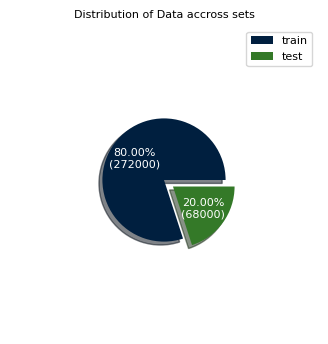

In [186]:
dist_sets = {'train': len(train), 'test': len(test)}

def fmt(x, total):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)

colors = ['#001F3F', '#347928']

plt.figure(figsize=(4, 4))
plt.title("Distribution of Data accross sets", fontsize=8)
plt.pie(
    dist_sets.values(), labels=dist_sets.keys(), autopct=lambda x: fmt(x, len(balanced_df)),
    textprops={'color': 'white', 'fontsize':8}, radius=.5, explode=[.0, .09],
    colors=colors, shadow=True,
)
plt.legend(fontsize=8)
plt.show()

We can see that out of all the data in the dataset, `20%` belongs to the testing data and `80%` belongs to the training data. Now that we have split our data what's next??




### Extract features and labels.
Next we are going to get the train features and labels as well as the test features and labels. Our labels are `text` but our features are numbers but some of the features are `text` as well such as [color, source]. However, machine learning algorithims understand numbers. We need a way of converting these labels into numbers. There are many ways of doing this but in this case i will use the simple one. First i will use the get my labels and use the `LabelEncoder` to change these labels to numbers.


> 🤔 Remember, our features are all the columns expect the `target` in the dataframe.

In [187]:
train_features = train.drop(["target"],axis=1).reset_index(drop=True)
train_labels = train["target"].values

test_features = test.drop(["target"],axis=1).reset_index(drop=True)
test_labels = test["target"].values

In [188]:
train.shape, test.shape

((272000, 20), (68000, 20))

In [189]:
train_labels

array(['good', 'bad', 'good', ..., 'bad', 'good', 'bad'], dtype=object)

In [190]:
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)
train_labels[:2]

array([1, 0])

In [191]:
label_encoder.inverse_transform(train_labels[:2])

array(['good', 'bad'], dtype=object)

In [192]:
label_encoder.classes_

array(['bad', 'good'], dtype=object)

Next let's get the features that are categorical and features that are numerical.

In [193]:
categorical_columns = np.array(['source', 'color'])
numerical_columns = np.array([i for i in train_features.columns if i not in categorical_columns])

Our labels has been endoded or they are now numerical. What's next??


### Scaling Features.


Our feature are number, however they need to be scaled. So we are going to create a pipeline that will work on tranforming our data in the way that we want. We are going to use something called `ColumnTransformer` from sklearn. We are going to encode each column surperately and scale the features in a pipeline. Here are the transformations that we are going to make for our features.

1. For all the numerical column features we are going to use the `StandardScaler`
2. For all the categorical features we are going to use the `OrdinalEncoder` and then apply `StandardScaler` after they have been encoded to numbers.


### Refs
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
- https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.OrdinalEncoder.html


In [194]:
scale_pipeline = Pipeline([
  ('standard_scaler', StandardScaler())
])
enode_and_scale_pipeline = Pipeline([
  ('odinal_scaler', OrdinalEncoder()),
  ('standard_scaler', StandardScaler())
])
ct = ColumnTransformer([
    ("numerical-columns", scale_pipeline,  numerical_columns),
    ("categorical-columns", enode_and_scale_pipeline, categorical_columns),
])
train_features_transformed = ct.fit_transform(train_features)
# on the test data we are only going to transform it
test_features_transformed = ct.transform(test_features)

In [195]:
train_features_transformed[0]

array([-1.60252044, -0.27366324,  2.89296696, -0.40633415, -0.05307583,
        0.22258306, -0.5385236 ,  0.47320253, -0.7359    , -1.12524189,
        1.8120013 ,  1.85929864, -0.78204485, -0.2418349 ,  0.02573381,
        1.93337575,  1.03992703,  1.09050062,  0.85916973])

In [196]:
test_features_transformed[0].shape

(19,)

### Feature Importance

Next we are going to use the `XGBoost` algorithim to learn feature importance based on the data that we have.

In [197]:
xgb_model = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=1000,
    early_stopping_rounds=50,
    objective='reg:linear',
    max_depth=3,
    learning_rate=0.01
)

xgb_model.fit(
    train_features_transformed, train_labels,
    eval_set=[(train_features_transformed, train_labels), (test_features_transformed, test_labels)],
    verbose=100
)

[0]	validation_0-rmse:0.49850	validation_1-rmse:0.49849
[100]	validation_0-rmse:0.40945	validation_1-rmse:0.40912
[200]	validation_0-rmse:0.36956	validation_1-rmse:0.36932
[300]	validation_0-rmse:0.34963	validation_1-rmse:0.34945
[400]	validation_0-rmse:0.33894	validation_1-rmse:0.33891
[500]	validation_0-rmse:0.33302	validation_1-rmse:0.33313
[600]	validation_0-rmse:0.32991	validation_1-rmse:0.33012
[700]	validation_0-rmse:0.32800	validation_1-rmse:0.32830
[800]	validation_0-rmse:0.32662	validation_1-rmse:0.32701
[900]	validation_0-rmse:0.32537	validation_1-rmse:0.32583
[999]	validation_0-rmse:0.32452	validation_1-rmse:0.32504


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

Again just like what we did in the previous notebook we are going to visualize these features manually and see which are important and the threshhold that we will take.

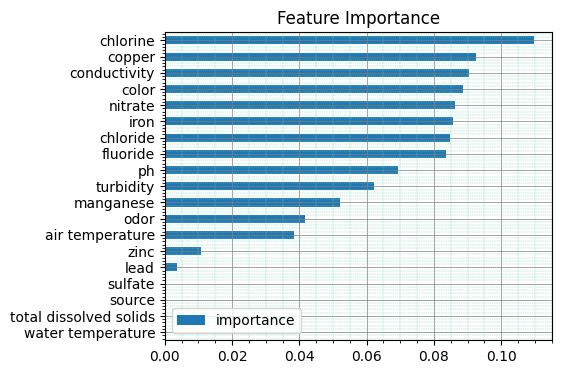

In [198]:
fi = pd.DataFrame(
    data=xgb_model.feature_importances_,
    index=train_features.columns,
    columns=['importance']
)
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(5, 4))
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

We can see that they are only few features that are important to detemine water quality which are based on a threshhold of `6%` which are:

```py
['ph', 'iron', 'nitrate', 'chloride', 'color', 'turbidity', 'fluoride', 'copper', 'conductivity', 'chlorine', ]
```

Next we are going to extract those features from our dataframe.

In [199]:
new_features = ['ph', 'iron', 'nitrate', 'chloride', 'color',
       'turbidity', 'fluoride', 'copper', 'conductivity',
       'chlorine',
       ]
train_features = train_features[new_features]
test_features = test_features[new_features]

train_features.head(2)

,ph,iron,nitrate,chloride,color,turbidity,fluoride,copper,conductivity,chlorine
0,5.846203,1.229082e-02,16.811835,160.354660,Near Colorless,0.047121,1.460870,0.081739,776.994695,2.694980
1,6.662065,1.250000e-08,4.199114,68.662872,Near Colorless,0.000323,0.514221,0.478685,525.749869,3.651851


Now the only categorical feature that we are left with is `color`. In the next code cell we are going to encode and scale our features.

In [200]:
categorical_columns = ['color']
numerical_columns = [i for i in train_features.columns if i not in categorical_columns]
scale_pipeline = Pipeline([
  ('standard_scaler', StandardScaler())
])
enode_and_scale_pipeline = Pipeline([
  ('odinal_scaler', OrdinalEncoder()),
  ('standard_scaler', StandardScaler())
])
ct = ColumnTransformer([
    ("numerical-columns", scale_pipeline,  numerical_columns),
    ("categorical-columns", enode_and_scale_pipeline, categorical_columns),
])
train_features_transformed = ct.fit_transform(train_features)
test_features_transformed = ct.transform(test_features)

train_features_transformed.shape, test_features_transformed.shape

((272000, 10), (68000, 10))

In [201]:
train_features_transformed[0]

array([-1.60252044, -0.27366324,  2.89296696, -0.40633415, -0.5385236 ,
        0.47320253, -0.7359    ,  1.85929864, -0.78204485,  0.85916973])

### Dimesionality Reduction
In the following code cell we are going to reduce the deminsions of our feature using `PCA`. We are going to make to reduce our features to be `3` and we will plot them using `3D` plot.


In [202]:
pca = PCA(n_components=3)
pca.fit(train_features_transformed)
pca_ds = pd.DataFrame(pca.transform(train_features_transformed), columns=(["feature_1","feature_2", "feature_3"]))
pca_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
feature_1,272000.0,-1.034467e-17,1.158391,-2.846058,-0.820528,-0.224744,0.616372,9.856964
feature_2,272000.0,-6.530724e-18,1.000895,-3.813125,-0.691906,-0.085938,0.606126,6.257035
feature_3,272000.0,2.209997e-17,0.998742,-4.799526,-0.650938,-0.031164,0.617204,6.322266


We can see that now we have `3` features insteard of `10` that we had before. Next we are going to transform our train_features and test_features which are scaled and reduce the dimensionality using `PCA`

In [203]:
pca_train_features_transformed = pca.transform(train_features_transformed)
pca_test_features_transformed = pca.transform(test_features_transformed)
pca_train_features_transformed.shape, pca_test_features_transformed.shape

((272000, 3), (68000, 3))

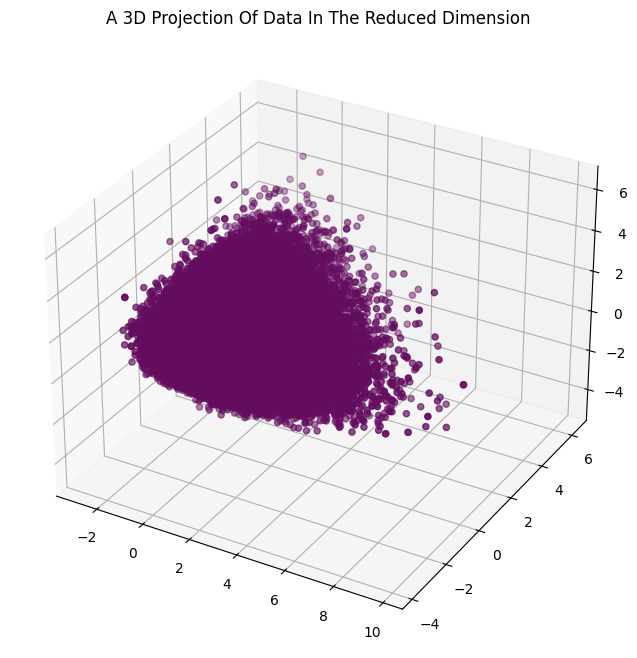

In [204]:
#A 3D Projection Of Data In The Reduced Dimension
x = pca_ds["feature_1"]
y = pca_ds["feature_2"]
z = pca_ds["feature_3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y ,z, c="#640D5F", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

### Deep Leaning Model

This time around we are going to build a Deep Leaning model. First things first, we need to create our dataset. But before we even do that let's generate a `validation` set from `training` set.

> The validation set is used during training to validate the model. This set should represent the test set as much as possible.

In [205]:
X_train, X_val, y_train, y_val = train_test_split(
    pca_train_features_transformed, train_labels, test_size=0.2, random_state=SEED
)
X_test = pca_test_features_transformed
y_test = test_labels

Let's visualize how the dataset is distributed accross sets after doing this split.

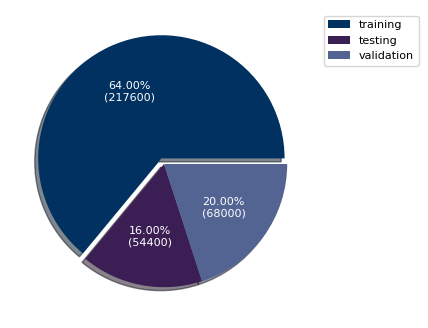

In [206]:
plt.figure(figsize=(4, 4))
plt.pie([len(X_train), len(X_val), len(X_test)], labels=['training', 'testing', 'validation'],
        autopct=lambda x: fmt(x, len(balanced_df)), textprops={'color': 'white', 'fontsize':8}, radius=1,
        colors=['#003161', '#3B1E54', '#536493', '#493628'],
        explode= [.05, 0, 0.0],
        shadow=True,
        )
plt.legend(fontsize=8, labels=['training', 'testing', 'validation'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Next we are going to create the `WaterQualityDataset`.

In [207]:
class WaterQualityDataset(Dataset):
    def __init__(self, y, X, transform=None):
        self.y = y
        self.X = X
        self.transform = transform

    def __getitem__(self, index):
        sample = self.X[index], self.y[index]
        if self.transform:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self.y)

Our dataset need to be converted to pytorch tensors so we need to create a `ToTensor` transformation class as follows:

In [208]:
class ToTensor:
  def __call__(self, samples):
    x, y = samples
    #  the labels will be torch float tensors since it is a binary classification.
    return torch.from_numpy(x.astype('float32')) ,torch.tensor(y).float()

Next we are going to create our datasets.

In [209]:
train_dataset = WaterQualityDataset(y_train, X_train, transform=ToTensor())
test_dataset = WaterQualityDataset(y_test, X_test, transform=ToTensor())
val_dataset = WaterQualityDataset(y_val, X_val, transform=ToTensor())

In [210]:
X_train.shape

(217600, 3)

### Iterators
In the following code cell we are going to create loaders using the DataLoader class from `torch.utils.data` for our `3` sets. We are going to use the `batch_size` of `128`. For the validation and testing dataset we are going to set the shuffle to `False` because there's no need fo us to shuffle these examples.

In [211]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Next we are going to check a single example.

In [212]:
feature, lbl = next(iter(train_loader))

In [213]:
feature[:2]

tensor([[ 0.9452, -1.2838,  0.6584],
        [-1.3195, -0.3105, -0.6736]])

In [214]:
lbl

tensor([1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
        0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
        1., 0.])

### Model

Next we are going to build a `WaterQualityModel` that will predict the water quality.

In [215]:
class WaterQualityModel(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(WaterQualityModel, self).__init__()
    self.linear = nn.Sequential(
      nn.Linear(input_dim,32),
      nn.ReLU(),
      nn.Linear(32,64),
      nn.ReLU()
    )
    self.out = nn.Sequential(
        nn.Linear(64, output_dim)
    )
  def forward(self, x):
    x = self.linear(x)
    return self.out(x)

Next we are going to create a model instance.

In [216]:
INPUT_DIM = feature.size()[1]
OUTPUT_DIM = 1 if len(label_encoder.classes_) == 2 else len(label_encoder.classes)
model = WaterQualityModel(input_dim=3, output_dim=1).to(device)
model

WaterQualityModel(
  (linear): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
  )
  (out): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
)

### Model Parameters
In the following code cell we are going to count parameters and visualize it using a table.

In [217]:

def count_trainable_params(model):
  return f"{sum(p.numel() for p in model.parameters()):,}", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

columns = ["MODEL", "TOTAL PARAMS", "TRAINABLE PARAMS"]
data = [
    ["water quality model", *count_trainable_params(model)],
]
tabulate_data(columns, data, title="Models Parameters")

Models Parameters
+---------------------+--------------+------------------+
| MODEL               | TOTAL PARAMS | TRAINABLE PARAMS |
+---------------------+--------------+------------------+
| water quality model |        2,305 |            2,305 |
+---------------------+--------------+------------------+


### Model Weights

Next we are going to initialize the model weights.MM

In [218]:
def initialize_weights(m):
  if isinstance(m, nn.Linear):
    nn.init.xavier_normal_(m.weight)
    nn.init.zeros_(m.bias)
model.apply(initialize_weights)

WaterQualityModel(
  (linear): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
  )
  (out): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
)

### Optimizer and Criterion
In the following code cell we are going to define the optimizer and loss function. For the optimizer we are going to use the `Adam` optimizer with default parameters and for the criterion we are going to use the `BCEWithLogitsLoss()` function since this is a binary classification.

In [219]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss().to(device)

In the following code cell we are going to create our `binary_accuracy` function, which is a function that calulates the the binary accuracy between the predicted labels and real labels.

In [220]:
def binary_accuracy(y_preds, y_true):
  rounded_preds = torch.round(torch.sigmoid(y_preds))
  correct = (rounded_preds == y_true).float()
  return correct.sum() / len(correct)

### Training and evaluation functions.

In the following code cell we are going to create our `train` and `evalute` functions:

In [221]:
def train(model, iterator, optimizer, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.train()
  for batch in iterator:
    X, y = batch
    X = X.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    predictions = model(X).squeeze(1)
    loss = criterion(predictions, y)
    acc = binary_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for batch in iterator:
      X, y = batch
      X = X.to(device)
      y = y.to(device)
      predictions = model(X).squeeze(1)
      loss = criterion(predictions, y)
      acc = binary_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Training Loop.
When training the model and we are also going to keep on tracking the training history of our model. The following `History` class is a data structure for our training history.

In [222]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, ett:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(ett)

In [223]:
def run_train_loop(model, model_name, train_loader, val_loader,  epochs=20, optimizer=None, criterion=None):
  best_valid_loss = float('inf')
  last_saved_epoch = 1
  history = History()
  training_start = time.time()
  for epoch in range(epochs):
    start = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    title = f"EPOCH: {epoch+1:02}/{epochs:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_name)
        last_saved_epoch = epoch+1
    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)
    data = [
        ["Training", f'{train_loss:.3f}', f'{train_acc:.3f}', f"{hms_string(end - start)}" ],
        ["Validation", f'{valid_loss:.3f}', f'{valid_acc:.3f}', "" ],
    ]
    columns = ["CATEGORY", "LOSS", "ACCURACY", "ETT"]
    tabulate_data(columns, data, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

In [224]:
EPOCHS = 30

history, ett, last_saved_epoch = run_train_loop(
    model, 'best-model.pt', train_loader, val_loader, EPOCHS,
    optimizer=optimizer, criterion=criterion
)

EPOCH: 01/30 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETT |
+------------+-------+----------+------------+
| Training   | 0.504 |    0.776 | 0:00:07.63 |
| Validation | 0.497 |    0.780 |            |
+------------+-------+----------+------------+
EPOCH: 02/30 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETT |
+------------+-------+----------+------------+
| Training   | 0.488 |    0.786 | 0:00:08.51 |
| Validation | 0.490 |    0.785 |            |
+------------+-------+----------+------------+
EPOCH: 03/30 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETT |
+------------+-------+----------+------------+
| Training   | 0.484 |    0.788 | 0:00:07.62 |
| Validation | 0.488 |    0.787 |            |
+------------+-------+----------+------------+
EPOCH: 04/30 not saving...
+------------+-------+---

Next we are going to check the the last saved epoch and the total training time our model took.

In [225]:
rows = [
      ["model", f'{EPOCHS}', f'{last_saved_epoch}', f'{hms_string(ett)}'],

]
tabulate_data(['MODEL', 'TOTAL EPOCHS', "LAST SAVED EPOCH", "TOTAL TRAINING TIME (s)"],
              rows, "MODEL'S TOTAL TRAINING TIME AND LAST SAVED EPOCH")

MODEL'S TOTAL TRAINING TIME AND LAST SAVED EPOCH
+-------+--------------+------------------+-------------------------+
| MODEL | TOTAL EPOCHS | LAST SAVED EPOCH | TOTAL TRAINING TIME (s) |
+-------+--------------+------------------+-------------------------+
| model |           30 |               27 |              0:04:02.66 |
+-------+--------------+------------------+-------------------------+


### Training History
In the following code cells we will be visualizing the training that we observed during training the model. The first plot that we will plot is about the training time that the model took to complete each epoch.

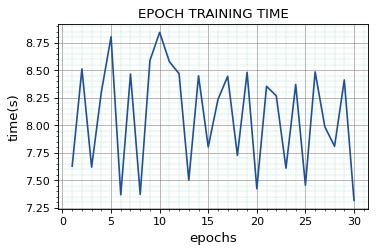

In [226]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time, color='#1F509A')
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to visualize the training and validation loss using a line graph for our model that was observed during model training.

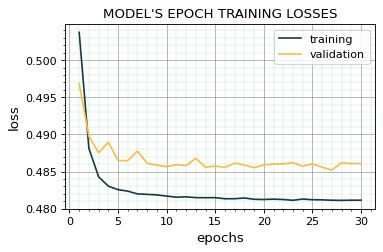

In [227]:

epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, color='#173B45', label='training')
plt.plot(epochs, history.val_losses, color='#FABC3F', label='validation')

plt.title("MODEL'S EPOCH TRAINING LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to visualize the training and validation accuracies using a line graph for our model that was observed during model training.

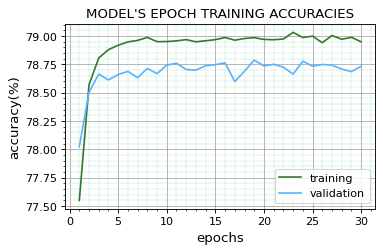

In [228]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, [acc * 100 for acc in history.train_acc], color='#347928', label='training')
plt.plot(epochs, [acc * 100 for acc in history.val_acc], color='#5AB2FF', label='validation')


plt.title("MODEL'S EPOCH TRAINING ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)
plt.legend(fontsize=10)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

### Best model evaluations.
In the following code cell we are going to evaluate the best saved model for our model achitecture.

In [229]:

model.load_state_dict(torch.load('best-model.pt'))
test_loss, test_acc = evaluate(model, test_loader, criterion)

rows = [
      ["model", f'{test_loss:.3f}', f'{test_acc*100:.2f}'],
]
tabulate_data(['MODEL', 'TEST LOSS', "TEST ACCURACY (%)"],
              rows, "BEST MODEL'S TESTING LOSS AND ACCURACY")

BEST MODEL'S TESTING LOSS AND ACCURACY
+-------+-----------+-------------------+
| MODEL | TEST LOSS | TEST ACCURACY (%) |
+-------+-----------+-------------------+
| model |     0.480 |             79.15 |
+-------+-----------+-------------------+


Next we are going to make predictions based with our test dataset for using our model.

In [230]:
def get_predictions(model, iterator, device):
  model.eval()
  labels = []
  predictions = []
  with torch.no_grad():
    for (X, y) in iterator:
      X = X.to(device)
      y_pred = model(X).squeeze(1)
      y_prob = F.sigmoid(y_pred).round().long()
      labels.append(y.cpu())
      predictions.append(y_prob.cpu())
  labels = torch.cat(labels, dim = 0).numpy()
  predictions = torch.cat(predictions, dim = 0).numpy()
  return labels, predictions
y_true, y_preds = get_predictions(model, test_loader, device)


### Model Performance
In this section we are going to have a look on how well our classifier model will be performing interms of the following metrics.

1. Confusion Matrix
2. Precision
3. Recall
4. F1 Score

### F1 Score
F1 score is a machine learning evaluation metric that measures a model's accuracy. It combines the precision and recall scores of a model. The accuracy metric computes how many times a model made a correct prediction across the entire dataset.

In [231]:
classes = label_encoder.classes_
scores = f1_score(y_true, y_preds, labels=np.array([0, 1]), average=None)

tabulate_data(['class', 'score'], list(zip(classes, scores)), "F1 SCORE IN THE TESTING DATASET")

F1 SCORE IN THE TESTING DATASET
+-------+--------------------+
| class |              score |
+-------+--------------------+
| bad   |  0.793657726915349 |
| good  | 0.7894768115511454 |
+-------+--------------------+


### Precision Score
Precision score measures the proportion of positively predicted labels that are actually correct.

In [232]:
scores = precision_score(y_true, y_preds, labels=np.array([0, 1]), average=None)

tabulate_data(['class', 'score'], list(zip(classes, scores)), "PRECISION IN THE TESTING DATASET")

PRECISION IN THE TESTING DATASET
+-------+--------------------+
| class |              score |
+-------+--------------------+
| bad   | 0.7864439058171745 |
| good  |  0.796934980806142 |
+-------+--------------------+


### Recall Score

Recall is the true positive rate, also referred to as sensitivity, which measures the probability of ground truth objects being correctly detected. Similarly, Recall ranges from 0 to 1, where a high recall score means that most ground truth objects were detected.

In [233]:
scores = recall_score(y_true, y_preds, labels=np.array([0, 1]), average=None)

tabulate_data(['class', 'score'], list(zip(classes, scores)), "RECALL IN THE TESTING DATASET")

RECALL IN THE TESTING DATASET
+-------+--------------------+
| class |              score |
+-------+--------------------+
| bad   | 0.8010051137365544 |
| good  | 0.7821569435450638 |
+-------+--------------------+


### Classification Report.

The classification report visualizer displays the `precision`, `recall`, `F1`, and support scores for the model.

In [234]:
cr = classification_report(y_true, y_preds, output_dict=False, target_names = classes)
print(cr)

              precision    recall  f1-score   support

         bad       0.79      0.80      0.79     34026
        good       0.80      0.78      0.79     33974

    accuracy                           0.79     68000
   macro avg       0.79      0.79      0.79     68000
weighted avg       0.79      0.79      0.79     68000



### Confusion Matrix
Next we are going to plot the confusion matrix and visually see how well our model is performing in predicting water quality given some features and how confused it is between these different classes.

In [235]:
cm = confusion_matrix(y_true, y_preds, labels=np.array([0, 1]))
print(cm)

[[27255  6771]
 [ 7401 26573]]


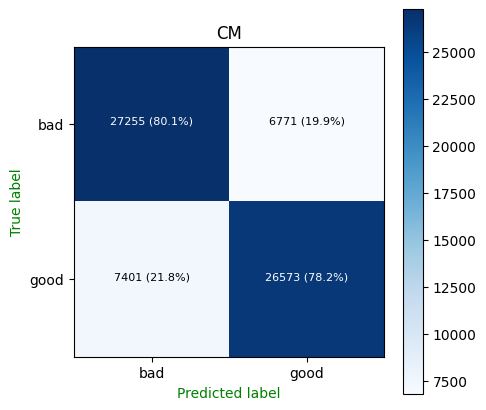

In [236]:
plot_complicated_confusion_matrix(y_true, y_preds,
  classes, fontsize=8, figsize=(5, 5), title="CM"
)

### Model Inference.

In this section we are going to make some predictions using our model.

Next we are going to use `Deep Leaning` to perform the same task.